In [5]:
import os
import tensorflow as tf
import numpy as np
import math
from random import sample, shuffle
from PIL import Image
import matplotlib.pyplot as plt
from src.DataGenerator import AudioDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Reshape, Conv2DTranspose, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from src.helper_functions import plot_reconstruction


In [4]:
data_gen = AudioDataGenerator(
    directory='data/Spotify/comp_pngs/', 
    image_size=(128,512), 
    color_mode='rgb',
    batch_size=64,
    sample_size=128000,
    shuffle=True,
    train_test_split=True, 
    test_size=0.02,
    output_channel_index=0,
    output_size=(128,128),
    threshold_level=0.5)



Found 125440 files for Training set
Found 2560 files for Test set


In [6]:
img_width = 128
img_height = 128
kernel_size = (3,3)
strides = (2,2)


class Autoencoder(tf.keras.Model):
    
    def __init__(self, latent_dim, num_channels):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Sequential([
            Conv2D(input_shape=(img_height, img_width, num_channels), filters=32, kernel_size=kernel_size, padding="same", strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Conv2D(filters=64, kernel_size=kernel_size, padding="same", strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Conv2D(filters=128, kernel_size=kernel_size, padding="same", strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Conv2D(filters=256, kernel_size=kernel_size, padding="same",strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Flatten(),
            Dense(units=latent_dim,)
        ])
        self.decoder = Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            Dense(units=16384, activation='relu'),
            BatchNormalization(axis=-1),
            Reshape(target_shape=(8,8,256)),
            Conv2DTranspose(filters=256, kernel_size=kernel_size, strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=128, kernel_size=kernel_size, strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=64, kernel_size=kernel_size,  strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=32, kernel_size=kernel_size,  strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=num_channels, kernel_size=kernel_size, padding="same", activation='sigmoid'),
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = Autoencoder(128, 1)

opt = Adam(learning_rate=1e-3)

autoencoder.compile(optimizer=opt, loss=tf.keras.losses.mse)

In [7]:
hist = autoencoder.fit(data_gen.train,
                       batch_size=data_gen.batch_size,
                       epochs=25,
                       validation_data=data_gen.test)

Epoch 1/25


2022-08-21 09:12:28.558125: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1960/1960 [==============================] - 1629s 830ms/step - loss: 0.0072 - val_loss: 0.0098
Epoch 2/25
1960/1960 [==============================] - 1643s 838ms/step - loss: 0.0057 - val_loss: 0.0060
Epoch 3/25
1960/1960 [==============================] - 1569s 800ms/step - loss: 0.0054 - val_loss: 0.0059
Epoch 4/25
1960/1960 [==============================] - 1339s 683ms/step - loss: 0.0053 - val_loss: 0.0091
Epoch 5/25
1960/1960 [==============================] - 1347s 687ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 6/25
1960/1960 [==============================] - 1349s 688ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 7/25
1960/1960 [==============================] - 1346s 687ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 8/25
1960/1960 [==============================] - 1346s 687ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 9/25
1960/1960 [==============================] - 1343s 685ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 10/25
1960/1960 [=========================

KeyboardInterrupt: 

<Figure size 1440x360 with 0 Axes>

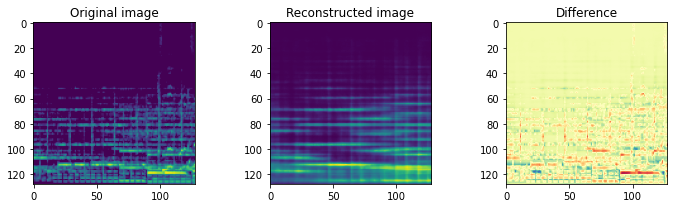

In [16]:
test_img = data_gen.take(5)[0]
encoding = autoencoder.encoder(test_img)
prediction = autoencoder(test_img)

plt.figure(figsize=(20,5))

plot_reconstruction(test_img, prediction, 1)

In [17]:
autoencoder_path = 'data/autoencoder_wThreshold'
autoencoder.save(autoencoder_path)

INFO:tensorflow:Assets written to: data/autoencoder_wThreshold/assets


INFO:tensorflow:Assets written to: data/autoencoder_wThreshold/assets


In [ ]:
from src.LatentSpace import LatentSpace

latent_space = LatentSpace(autoencoder_path=autoencoder_path,
                        image_dir='data/Spotify/comp_pngs/',
                        tracks_feather_path='data/all_tracks.feather', latent_dims=128, output_size=(128, 128),
                        threshold_level=0.5
                        )

In [ ]:
latent_space.build()
latent_space.save(autoencoder_path)